In [1]:
# -*- coding: utf-8 -*-
from maincode.function import load_json
import glob
import os
from sklearn.cluster import KMeans
from sklearn import decomposition
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import config as config
import pandas as pd
import tensorflow as tf
import librosa
import random
import numpy as np
import pandas as pd
import config as config
from maincode.trainer import ModelTrainer
from maincode.dataloader import AudioDataLoader
from models.dense import DenseClassifier
from maincode.function import set_seeds, export_hyperparams

ModuleNotFoundError: No module named 'tensorflow_hub'

##Predefined handlers

In [3]:
class Augmentations:
    """Audio augmentations"""

    def __init__(self):
        pass

    def time_stretch(self, audio, rate=None):
        if rate is None:
            rate = random.uniform(0.8, 1.2)  # random rate between 0.8x and 1.2x
        return librosa.effects.time_stretch(y=audio, rate=rate)

    def pitch_shift(self, audio, sr, n_steps=None):
        if n_steps is None:
            n_steps = random.uniform(-1, 1)  # random pitch shift between -1 and 1
        return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

    def add_noise(self, audio, noise_level=None):
        if noise_level is None:
            noise_level = random.uniform(0.001, 0.005)  # add random noise
        noise = np.random.randn(len(audio))
        return audio + noise_level * noise

    def random_crop(self, audio, sr, target_duration):
        target_length = int(sr * target_duration)
        if len(audio) >= target_length:
            start = random.randint(0, len(audio) - target_length)
            return audio[start : start + target_length]
        return audio

    def change_volume(self, audio, volume_change=None):
        if volume_change is None:
            volume_change = random.uniform(0.5, 1.5)  # random volume change
        return audio * volume_change

    def pad_clip(self, audio, sr, target_duration):
        target_length = int(sr * target_duration)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        elif len(audio) > target_length:
            audio = audio[:target_length]
        return audio

    def apply_augmentations(self, audio, sr, target_duration):
        audio = self.time_stretch(audio)
        audio = self.pitch_shift(audio, sr)
        audio = self.add_noise(audio)
        audio = self.change_volume(audio)
        audio = self.random_crop(audio, sr, target_duration)
        audio = self.pad_clip(audio, sr, target_duration)
        return audio

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize(embedding, label):
    """Serialize the embeddings and label to a tfrecord proto."""
    feature = {
        "feature": _bytes_feature(tf.io.serialize_tensor(embedding)),
        "label": _int64_feature(label),
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto.SerializeToString()


def write_tfrecord(target_path, embeddings, label):
    """Write the embeddings and label to a tfrecord file."""
    # wintarget_path=target_path.split('\\')
    # tfwintarget_path=os.path.join(wintarget_path[0],wintarget_path[1])
    # if not os.path.exists(tfwintarget_path):
    #     os.makedirs(tfwintarget_path)
    with tf.io.TFRecordWriter(target_path) as writer:
        serialized_example = serialize(embeddings.numpy(), label)
        writer.write(serialized_example)


def consolidate_labels(labels_path):
    """Consolidate the labels to the highest relevance instrument per class."""
    agg_labels = pd.read_csv(labels_path)
    agg_labels = (
        agg_labels.groupby("sample_key")
        .agg({"instrument": lambda x: x.iloc[np.argmax(x.values)]})
        .reset_index()
    )
    return agg_labels


def load_label(labels_df, class_map, file_name):
    """Load the label for a given file name."""
    file_name = file_name.split("\\")[-1].split(".")[0]
    label = labels_df.loc[labels_df["sample_key"] == file_name, "instrument"].values[0]
    label_index = class_map[label]
    return label_index


def pad_clip(audio, sr, target_duration):
    target_length = int(sr * target_duration)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        audio = audio[:target_length]
    return audio


def load_and_preprocess_audio(
    model, model_name, out_dim, file_path, target_duration=10, target_sr=16000
):
    """Load, resample and feature extract from the audio files."""
    audio, sr = librosa.load(file_path, sr=None, mono=True)  # load audio

    if sr != target_sr:  # resample as needed
        audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    if config.AUGMENT:
        audio = augmentations.apply_augmentations(audio, sr, target_duration)

    else:
        audio = pad_clip(audio, sr, target_duration)

    # forward pass to get the embeddings
    output = model(audio)

    if model_name == "vggish":
        embeddings = output
    elif model_name == "yamnet":
        _, embeddings, log_mel_spectrogram = output

    else:
        raise ValueError("Invalid model name")

    # sanity check
    embeddings.shape.assert_is_compatible_with([None, out_dim])

    return embeddings



#preprocess and EDA

Data table format

          sample_key instrument
0        000046_3840    trumpet
1      000135_483840      voice
2      000139_119040  accordion
3      000141_153600   clarinet
4       000144_30720    ukulele
...              ...        ...
19995  155294_184320     violin
19996   155295_76800     violin
19997  155307_211200   trombone
19998  155310_372480  saxophone
19999  155311_453120    trumpet

[20000 rows x 2 columns]
Category histogram for each class



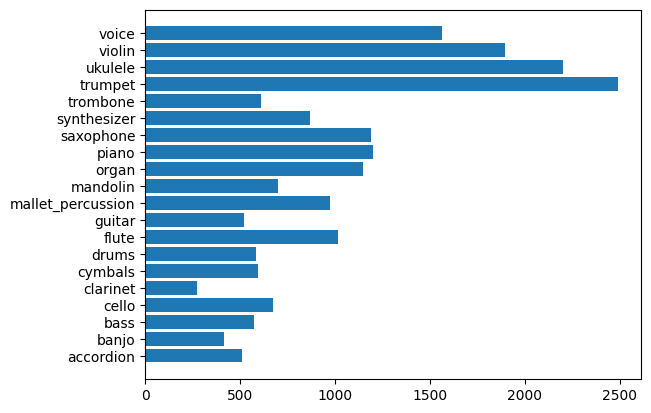

C:\Users\26387\anaconda3\envs\tfkeras\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


data cluster after PCA



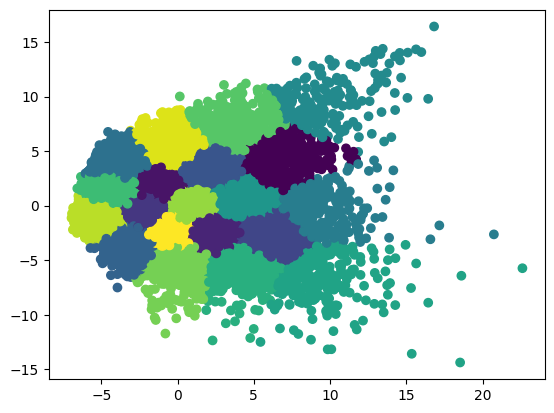

In [6]:
###get the vggisg feature extract model
model_name, model_args=list(config.MODELS.items())[0]
model_url = model_args.get("url")
out_dim = model_args.get("out_dim")
model = hub.load(model_url)
##get filepath
filepaths = glob.glob(f"{config.AUDIO_DIR}\\*\\*.ogg")
target_filepaths = ["\\".join(fp.split("\\")[-1:]) for fp in filepaths]
fpath=os.path.join(config.TARGET_AUDIO_DIR,model_name+"_features")
if not os.path.exists(fpath):
    os.mkdir(fpath)
labels_df = consolidate_labels(config.LABELS_PATH)
print('Data table format\n')
print(labels_df)
###
instrum=['accordion', 'banjo', 'bass', 'cello', 'clarinet',
'cymbals', 'drums', 'flute', 'guitar', 'mallet_percussion', 'mandolin', 'organ', 'piano', 'saxophone', 'synthesizer',
'trombone', 'trumpet', 'ukulele', 'violin', 'voice']
num=[]
##Category histogram for EDA
for i in instrum:
    num.append(list(labels_df['instrument']).count(i))
num=np.asarray(num)
print('Category histogram for each class\n')
plt.barh(instrum, width=num)
plt.show()
###all instrument class
class_map = load_json(config.LABELS_MAP_PATH)
#  augmentations
augmentations = Augmentations()
# preprocess each file and save to thrcord
audioembed=[]
##get the embedding and label for each file
for i in range(len(filepaths)):
    fp=filepaths[i]
    target_path = f"{config.TARGET_AUDIO_DIR}\\{model_name}_features\\{target_filepaths[i]}".replace(".ogg", ".tfrecord")
    embeddings = load_and_preprocess_audio(model,model_name,out_dim,fp,
    target_duration=config.TARGET_DURATION,target_sr=config.TARGET_SAMPLE_RATE,)
    reemb=np.asarray(embeddings).reshape(1280)
    audioembed.append(reemb)
    label = load_label(labels_df=labels_df,class_map=class_map,file_name=target_filepaths[i],)
    write_tfrecord(target_path, embeddings, label)
###do PCA and cluster for EDA
model = decomposition.PCA(n_components=2)
model.fit(audioembed)
new = model.fit_transform(audioembed)
y_pred = KMeans(n_clusters=20, random_state=9).fit_predict(new)
print('data cluster after PCA\n')
plt.scatter(new[:, 0], new[:, 1], c=y_pred)
plt.show()


###train and output the metrics

Epoch 1/100
     77/Unknown - 3s 7ms/step - loss: 12.5384 - precision_1: 0.7998 - recall_1: 0.0721 - f1_score: 0.3706WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 3s 8ms/step - loss: 12.4550 - precision_1: 0.8022 - recall_1: 0.0769 - f1_score: 0.3767
Epoch 2/100
80/82 [============================>.] - ETA: 0s - loss: 9.7982 - precision_1: 0.8066 - recall_1: 0.1963 - f1_score: 0.5094WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 9.7770 - precision_1: 0.8063 - recall_1: 0.1978 - f1_score: 0.5101
Epoch 3/100
74/82 [==========================>...] - ETA: 0s - loss: 7.9474 - precision_1: 0.8134 - recall_1: 0.2452 - f1_score: 0.5474WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 7.8772 - precision_1: 0.8113 - recall_1: 0.2458 - f1_score: 0.5472
Epoch 4/100
76/82 [==========================>...] - ETA: 0s - loss: 6.5071 - precision_1: 0.8098 - recall_1: 0.2810 - f1_score: 0.5676WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 6.4646 - precision_1: 0.8079 - recall_1: 0.2816 - f1_score: 0.5682
Epoch 5/100
79/82 [===========================>..] - ETA: 0s - loss: 5.3987 - precision_1: 0.8175 - recall_1: 0.2972 - f1_score: 0.5879WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 5.3830 - precision_1: 0.8191 - recall_1: 0.2979 - f1_score: 0.5889
Epoch 6/100
75/82 [==========================>...] - ETA: 0s - loss: 4.5895 - precision_1: 0.8224 - recall_1: 0.3178 - f1_score: 0.5969WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 4.5612 - precision_1: 0.8224 - recall_1: 0.3181 - f1_score: 0.5976
Epoch 7/100
81/82 [============================>.] - ETA: 0s - loss: 3.9271 - precision_1: 0.8195 - recall_1: 0.3257 - f1_score: 0.6067WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 3.9257 - precision_1: 0.8200 - recall_1: 0.3259 - f1_score: 0.6068
Epoch 8/100
81/82 [============================>.] - ETA: 0s - loss: 3.4401 - precision_1: 0.8243 - recall_1: 0.3388 - f1_score: 0.6123WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 3.4380 - precision_1: 0.8246 - recall_1: 0.3391 - f1_score: 0.6120
Epoch 9/100
79/82 [===========================>..] - ETA: 0s - loss: 3.0557 - precision_1: 0.8279 - recall_1: 0.3478 - f1_score: 0.6155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 3.0511 - precision_1: 0.8281 - recall_1: 0.3475 - f1_score: 0.6155
Epoch 10/100
78/82 [===========================>..] - ETA: 0s - loss: 2.7514 - precision_1: 0.8347 - recall_1: 0.3541 - f1_score: 0.6263WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 2.7448 - precision_1: 0.8337 - recall_1: 0.3545 - f1_score: 0.6267
Epoch 11/100
77/82 [===========================>..] - ETA: 0s - loss: 2.5191 - precision_1: 0.8253 - recall_1: 0.3585 - f1_score: 0.6248WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 2.5111 - precision_1: 0.8274 - recall_1: 0.3586 - f1_score: 0.6272
Epoch 12/100
76/82 [==========================>...] - ETA: 0s - loss: 2.3151 - precision_1: 0.8342 - recall_1: 0.3744 - f1_score: 0.6344WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 2.3179 - precision_1: 0.8348 - recall_1: 0.3718 - f1_score: 0.6308
Epoch 13/100
80/82 [============================>.] - ETA: 0s - loss: 2.1667 - precision_1: 0.8373 - recall_1: 0.3724 - f1_score: 0.6370WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 2.1661 - precision_1: 0.8371 - recall_1: 0.3716 - f1_score: 0.6367
Epoch 14/100
78/82 [===========================>..] - ETA: 0s - loss: 2.0416 - precision_1: 0.8371 - recall_1: 0.3787 - f1_score: 0.6401WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 2.0382 - precision_1: 0.8369 - recall_1: 0.3785 - f1_score: 0.6408
Epoch 15/100
82/82 [==============================] - ETA: 0s - loss: 1.9412 - precision_1: 0.8403 - recall_1: 0.3831 - f1_score: 0.6424WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.9412 - precision_1: 0.8403 - recall_1: 0.3831 - f1_score: 0.6424
Epoch 16/100
80/82 [============================>.] - ETA: 0s - loss: 1.8640 - precision_1: 0.8405 - recall_1: 0.3859 - f1_score: 0.6466WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.8644 - precision_1: 0.8394 - recall_1: 0.3854 - f1_score: 0.6458
Epoch 17/100
81/82 [============================>.] - ETA: 0s - loss: 1.7941 - precision_1: 0.8423 - recall_1: 0.3864 - f1_score: 0.6445WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.7953 - precision_1: 0.8416 - recall_1: 0.3862 - f1_score: 0.6440
Epoch 18/100
79/82 [===========================>..] - ETA: 0s - loss: 1.7363 - precision_1: 0.8434 - recall_1: 0.3946 - f1_score: 0.6509WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.7389 - precision_1: 0.8416 - recall_1: 0.3938 - f1_score: 0.6498
Epoch 19/100
79/82 [===========================>..] - ETA: 0s - loss: 1.6888 - precision_1: 0.8446 - recall_1: 0.4015 - f1_score: 0.6564WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.6904 - precision_1: 0.8451 - recall_1: 0.4008 - f1_score: 0.6552
Epoch 20/100
81/82 [============================>.] - ETA: 0s - loss: 1.6505 - precision_1: 0.8409 - recall_1: 0.4017 - f1_score: 0.6525WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.6506 - precision_1: 0.8409 - recall_1: 0.4015 - f1_score: 0.6525
Epoch 21/100
82/82 [==============================] - ETA: 0s - loss: 1.6205 - precision_1: 0.8435 - recall_1: 0.3990 - f1_score: 0.6558WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.6205 - precision_1: 0.8435 - recall_1: 0.3990 - f1_score: 0.6558
Epoch 22/100
80/82 [============================>.] - ETA: 0s - loss: 1.5898 - precision_1: 0.8520 - recall_1: 0.4087 - f1_score: 0.6565WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.5936 - precision_1: 0.8515 - recall_1: 0.4074 - f1_score: 0.6554
Epoch 23/100
76/82 [==========================>...] - ETA: 0s - loss: 1.5586 - precision_1: 0.8426 - recall_1: 0.4144 - f1_score: 0.6589WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.5636 - precision_1: 0.8424 - recall_1: 0.4127 - f1_score: 0.6582
Epoch 24/100
81/82 [============================>.] - ETA: 0s - loss: 1.5475 - precision_1: 0.8520 - recall_1: 0.4116 - f1_score: 0.6598WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.5463 - precision_1: 0.8512 - recall_1: 0.4120 - f1_score: 0.6602
Epoch 25/100
76/82 [==========================>...] - ETA: 0s - loss: 1.5215 - precision_1: 0.8433 - recall_1: 0.4166 - f1_score: 0.6615WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.5220 - precision_1: 0.8427 - recall_1: 0.4173 - f1_score: 0.6622
Epoch 26/100
74/82 [==========================>...] - ETA: 0s - loss: 1.5067 - precision_1: 0.8464 - recall_1: 0.4207 - f1_score: 0.6663WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.5067 - precision_1: 0.8470 - recall_1: 0.4195 - f1_score: 0.6671
Epoch 27/100
75/82 [==========================>...] - ETA: 0s - loss: 1.4875 - precision_1: 0.8444 - recall_1: 0.4201 - f1_score: 0.6652WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.4888 - precision_1: 0.8446 - recall_1: 0.4218 - f1_score: 0.6656
Epoch 28/100
78/82 [===========================>..] - ETA: 0s - loss: 1.4782 - precision_1: 0.8480 - recall_1: 0.4248 - f1_score: 0.6694WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.4787 - precision_1: 0.8476 - recall_1: 0.4247 - f1_score: 0.6693
Epoch 29/100
77/82 [===========================>..] - ETA: 0s - loss: 1.4684 - precision_1: 0.8446 - recall_1: 0.4242 - f1_score: 0.6672WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.4677 - precision_1: 0.8466 - recall_1: 0.4261 - f1_score: 0.6670
Epoch 30/100
78/82 [===========================>..] - ETA: 0s - loss: 1.4558 - precision_1: 0.8468 - recall_1: 0.4297 - f1_score: 0.6651WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.4570 - precision_1: 0.8471 - recall_1: 0.4289 - f1_score: 0.6649
Epoch 31/100
77/82 [===========================>..] - ETA: 0s - loss: 1.4494 - precision_1: 0.8541 - recall_1: 0.4287 - f1_score: 0.6693WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.4474 - precision_1: 0.8543 - recall_1: 0.4308 - f1_score: 0.6694
Epoch 32/100
82/82 [==============================] - ETA: 0s - loss: 1.4362 - precision_1: 0.8500 - recall_1: 0.4353 - f1_score: 0.6745WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.4362 - precision_1: 0.8500 - recall_1: 0.4353 - f1_score: 0.6745
Epoch 33/100
76/82 [==========================>...] - ETA: 0s - loss: 1.4308 - precision_1: 0.8586 - recall_1: 0.4365 - f1_score: 0.6743WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.4281 - precision_1: 0.8576 - recall_1: 0.4378 - f1_score: 0.6754
Epoch 34/100
78/82 [===========================>..] - ETA: 0s - loss: 1.4141 - precision_1: 0.8541 - recall_1: 0.4439 - f1_score: 0.6745WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.4175 - precision_1: 0.8541 - recall_1: 0.4422 - f1_score: 0.6736
Epoch 35/100
74/82 [==========================>...] - ETA: 0s - loss: 1.4110 - precision_1: 0.8509 - recall_1: 0.4416 - f1_score: 0.6799WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.4063 - precision_1: 0.8516 - recall_1: 0.4437 - f1_score: 0.6811
Epoch 36/100
78/82 [===========================>..] - ETA: 0s - loss: 1.3987 - precision_1: 0.8540 - recall_1: 0.4451 - f1_score: 0.6818WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3972 - precision_1: 0.8553 - recall_1: 0.4455 - f1_score: 0.6828
Epoch 37/100
76/82 [==========================>...] - ETA: 0s - loss: 1.3870 - precision_1: 0.8573 - recall_1: 0.4497 - f1_score: 0.6837WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.3923 - precision_1: 0.8559 - recall_1: 0.4479 - f1_score: 0.6812
Epoch 38/100
81/82 [============================>.] - ETA: 0s - loss: 1.3893 - precision_1: 0.8538 - recall_1: 0.4483 - f1_score: 0.6821WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3895 - precision_1: 0.8539 - recall_1: 0.4480 - f1_score: 0.6814
Epoch 39/100
76/82 [==========================>...] - ETA: 0s - loss: 1.3753 - precision_1: 0.8589 - recall_1: 0.4550 - f1_score: 0.6850WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.3770 - precision_1: 0.8588 - recall_1: 0.4550 - f1_score: 0.6850
Epoch 40/100
82/82 [==============================] - ETA: 0s - loss: 1.3736 - precision_1: 0.8566 - recall_1: 0.4564 - f1_score: 0.6823WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 9ms/step - loss: 1.3736 - precision_1: 0.8566 - recall_1: 0.4564 - f1_score: 0.6823
Epoch 41/100
76/82 [==========================>...] - ETA: 0s - loss: 1.3696 - precision_1: 0.8525 - recall_1: 0.4532 - f1_score: 0.6853WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.3665 - precision_1: 0.8541 - recall_1: 0.4559 - f1_score: 0.6858
Epoch 42/100
77/82 [===========================>..] - ETA: 0s - loss: 1.3603 - precision_1: 0.8596 - recall_1: 0.4598 - f1_score: 0.6912WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3619 - precision_1: 0.8603 - recall_1: 0.4584 - f1_score: 0.6896
Epoch 43/100
80/82 [============================>.] - ETA: 0s - loss: 1.3611 - precision_1: 0.8541 - recall_1: 0.4591 - f1_score: 0.6852WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3592 - precision_1: 0.8549 - recall_1: 0.4592 - f1_score: 0.6864
Epoch 44/100
80/82 [============================>.] - ETA: 0s - loss: 1.3484 - precision_1: 0.8561 - recall_1: 0.4661 - f1_score: 0.6936WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3501 - precision_1: 0.8552 - recall_1: 0.4666 - f1_score: 0.6930
Epoch 45/100
79/82 [===========================>..] - ETA: 0s - loss: 1.3407 - precision_1: 0.8594 - recall_1: 0.4665 - f1_score: 0.6924WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3397 - precision_1: 0.8605 - recall_1: 0.4661 - f1_score: 0.6928
Epoch 46/100
82/82 [==============================] - ETA: 0s - loss: 1.3392 - precision_1: 0.8577 - recall_1: 0.4705 - f1_score: 0.6912WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3392 - precision_1: 0.8577 - recall_1: 0.4705 - f1_score: 0.6912
Epoch 47/100
82/82 [==============================] - ETA: 0s - loss: 1.3314 - precision_1: 0.8627 - recall_1: 0.4706 - f1_score: 0.6944WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3314 - precision_1: 0.8627 - recall_1: 0.4706 - f1_score: 0.6944
Epoch 48/100
79/82 [===========================>..] - ETA: 0s - loss: 1.3302 - precision_1: 0.8590 - recall_1: 0.4686 - f1_score: 0.6968WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3308 - precision_1: 0.8592 - recall_1: 0.4681 - f1_score: 0.6965
Epoch 49/100
74/82 [==========================>...] - ETA: 0s - loss: 1.3276 - precision_1: 0.8619 - recall_1: 0.4743 - f1_score: 0.6925WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.3297 - precision_1: 0.8614 - recall_1: 0.4738 - f1_score: 0.6910
Epoch 50/100
79/82 [===========================>..] - ETA: 0s - loss: 1.3204 - precision_1: 0.8567 - recall_1: 0.4729 - f1_score: 0.7000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3229 - precision_1: 0.8567 - recall_1: 0.4729 - f1_score: 0.6989
Epoch 51/100
76/82 [==========================>...] - ETA: 0s - loss: 1.3205 - precision_1: 0.8616 - recall_1: 0.4762 - f1_score: 0.6962WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3220 - precision_1: 0.8610 - recall_1: 0.4762 - f1_score: 0.6958
Epoch 52/100
77/82 [===========================>..] - ETA: 0s - loss: 1.3180 - precision_1: 0.8611 - recall_1: 0.4747 - f1_score: 0.6949WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3170 - precision_1: 0.8612 - recall_1: 0.4766 - f1_score: 0.6968
Epoch 53/100
76/82 [==========================>...] - ETA: 0s - loss: 1.2997 - precision_1: 0.8652 - recall_1: 0.4861 - f1_score: 0.7055WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3072 - precision_1: 0.8630 - recall_1: 0.4851 - f1_score: 0.7031
Epoch 54/100
76/82 [==========================>...] - ETA: 0s - loss: 1.2979 - precision_1: 0.8671 - recall_1: 0.4877 - f1_score: 0.7023WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.3022 - precision_1: 0.8653 - recall_1: 0.4868 - f1_score: 0.7000
Epoch 55/100
82/82 [==============================] - ETA: 0s - loss: 1.2991 - precision_1: 0.8656 - recall_1: 0.4826 - f1_score: 0.7069WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2991 - precision_1: 0.8656 - recall_1: 0.4826 - f1_score: 0.7069
Epoch 56/100
75/82 [==========================>...] - ETA: 0s - loss: 1.2883 - precision_1: 0.8639 - recall_1: 0.4895 - f1_score: 0.7091WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2968 - precision_1: 0.8614 - recall_1: 0.4882 - f1_score: 0.7065
Epoch 57/100
76/82 [==========================>...] - ETA: 0s - loss: 1.2846 - precision_1: 0.8696 - recall_1: 0.4915 - f1_score: 0.7033WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2902 - precision_1: 0.8677 - recall_1: 0.4907 - f1_score: 0.7013
Epoch 58/100
77/82 [===========================>..] - ETA: 0s - loss: 1.2870 - precision_1: 0.8675 - recall_1: 0.4914 - f1_score: 0.7109WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2854 - precision_1: 0.8680 - recall_1: 0.4920 - f1_score: 0.7098
Epoch 59/100
80/82 [============================>.] - ETA: 0s - loss: 1.2778 - precision_1: 0.8663 - recall_1: 0.4941 - f1_score: 0.7134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2777 - precision_1: 0.8655 - recall_1: 0.4939 - f1_score: 0.7128
Epoch 60/100
77/82 [===========================>..] - ETA: 0s - loss: 1.2704 - precision_1: 0.8668 - recall_1: 0.5023 - f1_score: 0.7119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2748 - precision_1: 0.8662 - recall_1: 0.5006 - f1_score: 0.7100
Epoch 61/100
81/82 [============================>.] - ETA: 0s - loss: 1.2730 - precision_1: 0.8625 - recall_1: 0.4967 - f1_score: 0.7089WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2730 - precision_1: 0.8624 - recall_1: 0.4965 - f1_score: 0.7088
Epoch 62/100
75/82 [==========================>...] - ETA: 0s - loss: 1.2736 - precision_1: 0.8694 - recall_1: 0.5013 - f1_score: 0.7094WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.2732 - precision_1: 0.8674 - recall_1: 0.5021 - f1_score: 0.7094
Epoch 63/100
77/82 [===========================>..] - ETA: 0s - loss: 1.2613 - precision_1: 0.8691 - recall_1: 0.5045 - f1_score: 0.7153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.2626 - precision_1: 0.8689 - recall_1: 0.5034 - f1_score: 0.7142
Epoch 64/100
73/82 [=========================>....] - ETA: 0s - loss: 1.2559 - precision_1: 0.8701 - recall_1: 0.5037 - f1_score: 0.7186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.2555 - precision_1: 0.8717 - recall_1: 0.5043 - f1_score: 0.7187
Epoch 65/100
82/82 [==============================] - ETA: 0s - loss: 1.2550 - precision_1: 0.8688 - recall_1: 0.5055 - f1_score: 0.7157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.2550 - precision_1: 0.8688 - recall_1: 0.5055 - f1_score: 0.7157
Epoch 66/100
74/82 [==========================>...] - ETA: 0s - loss: 1.2496 - precision_1: 0.8674 - recall_1: 0.5041 - f1_score: 0.7181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2519 - precision_1: 0.8670 - recall_1: 0.5019 - f1_score: 0.7173
Epoch 67/100
75/82 [==========================>...] - ETA: 0s - loss: 1.2351 - precision_1: 0.8715 - recall_1: 0.5156 - f1_score: 0.7259WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2452 - precision_1: 0.8689 - recall_1: 0.5116 - f1_score: 0.7224
Epoch 68/100
79/82 [===========================>..] - ETA: 0s - loss: 1.2400 - precision_1: 0.8749 - recall_1: 0.5127 - f1_score: 0.7212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2431 - precision_1: 0.8742 - recall_1: 0.5111 - f1_score: 0.7210
Epoch 69/100
79/82 [===========================>..] - ETA: 0s - loss: 1.2372 - precision_1: 0.8719 - recall_1: 0.5129 - f1_score: 0.7225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2406 - precision_1: 0.8721 - recall_1: 0.5116 - f1_score: 0.7213
Epoch 70/100
76/82 [==========================>...] - ETA: 0s - loss: 1.2318 - precision_1: 0.8742 - recall_1: 0.5193 - f1_score: 0.7269WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2327 - precision_1: 0.8744 - recall_1: 0.5188 - f1_score: 0.7268
Epoch 71/100
77/82 [===========================>..] - ETA: 0s - loss: 1.2297 - precision_1: 0.8758 - recall_1: 0.5142 - f1_score: 0.7222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2287 - precision_1: 0.8767 - recall_1: 0.5163 - f1_score: 0.7225
Epoch 72/100
74/82 [==========================>...] - ETA: 0s - loss: 1.2277 - precision_1: 0.8720 - recall_1: 0.5185 - f1_score: 0.7232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2359 - precision_1: 0.8709 - recall_1: 0.5143 - f1_score: 0.7216
Epoch 73/100
78/82 [===========================>..] - ETA: 0s - loss: 1.2272 - precision_1: 0.8706 - recall_1: 0.5163 - f1_score: 0.7301WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2262 - precision_1: 0.8715 - recall_1: 0.5177 - f1_score: 0.7305
Epoch 74/100
81/82 [============================>.] - ETA: 0s - loss: 1.2200 - precision_1: 0.8719 - recall_1: 0.5226 - f1_score: 0.7274WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2193 - precision_1: 0.8722 - recall_1: 0.5224 - f1_score: 0.7278
Epoch 75/100
81/82 [============================>.] - ETA: 0s - loss: 1.2179 - precision_1: 0.8752 - recall_1: 0.5260 - f1_score: 0.7291WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2179 - precision_1: 0.8757 - recall_1: 0.5257 - f1_score: 0.7294
Epoch 76/100
80/82 [============================>.] - ETA: 0s - loss: 1.2046 - precision_1: 0.8774 - recall_1: 0.5311 - f1_score: 0.7288WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2049 - precision_1: 0.8775 - recall_1: 0.5299 - f1_score: 0.7289
Epoch 77/100
78/82 [===========================>..] - ETA: 0s - loss: 1.2018 - precision_1: 0.8801 - recall_1: 0.5278 - f1_score: 0.7340WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.2060 - precision_1: 0.8781 - recall_1: 0.5263 - f1_score: 0.7317
Epoch 78/100
81/82 [============================>.] - ETA: 0s - loss: 1.2045 - precision_1: 0.8792 - recall_1: 0.5291 - f1_score: 0.7323WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.2036 - precision_1: 0.8795 - recall_1: 0.5297 - f1_score: 0.7323
Epoch 79/100
80/82 [============================>.] - ETA: 0s - loss: 1.2005 - precision_1: 0.8796 - recall_1: 0.5324 - f1_score: 0.7319WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.2020 - precision_1: 0.8791 - recall_1: 0.5319 - f1_score: 0.7309
Epoch 80/100
79/82 [===========================>..] - ETA: 0s - loss: 1.1935 - precision_1: 0.8794 - recall_1: 0.5310 - f1_score: 0.7392WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1937 - precision_1: 0.8799 - recall_1: 0.5321 - f1_score: 0.7393
Epoch 81/100
74/82 [==========================>...] - ETA: 0s - loss: 1.1948 - precision_1: 0.8815 - recall_1: 0.5340 - f1_score: 0.7368WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1959 - precision_1: 0.8809 - recall_1: 0.5337 - f1_score: 0.7355
Epoch 82/100
81/82 [============================>.] - ETA: 0s - loss: 1.1944 - precision_1: 0.8766 - recall_1: 0.5360 - f1_score: 0.7344WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1951 - precision_1: 0.8766 - recall_1: 0.5360 - f1_score: 0.7342
Epoch 83/100
78/82 [===========================>..] - ETA: 0s - loss: 1.1805 - precision_1: 0.8776 - recall_1: 0.5394 - f1_score: 0.7423WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1840 - precision_1: 0.8771 - recall_1: 0.5381 - f1_score: 0.7402
Epoch 84/100
76/82 [==========================>...] - ETA: 0s - loss: 1.1795 - precision_1: 0.8853 - recall_1: 0.5401 - f1_score: 0.7434WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1822 - precision_1: 0.8827 - recall_1: 0.5392 - f1_score: 0.7416
Epoch 85/100
81/82 [============================>.] - ETA: 0s - loss: 1.1774 - precision_1: 0.8833 - recall_1: 0.5379 - f1_score: 0.7395WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1776 - precision_1: 0.8829 - recall_1: 0.5378 - f1_score: 0.7390
Epoch 86/100
80/82 [============================>.] - ETA: 0s - loss: 1.1764 - precision_1: 0.8858 - recall_1: 0.5453 - f1_score: 0.7433WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1751 - precision_1: 0.8865 - recall_1: 0.5459 - f1_score: 0.7438
Epoch 87/100
77/82 [===========================>..] - ETA: 0s - loss: 1.1721 - precision_1: 0.8826 - recall_1: 0.5475 - f1_score: 0.7454WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1749 - precision_1: 0.8804 - recall_1: 0.5452 - f1_score: 0.7436
Epoch 88/100
79/82 [===========================>..] - ETA: 0s - loss: 1.1690 - precision_1: 0.8801 - recall_1: 0.5492 - f1_score: 0.7443WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1688 - precision_1: 0.8797 - recall_1: 0.5499 - f1_score: 0.7444
Epoch 89/100
79/82 [===========================>..] - ETA: 0s - loss: 1.1612 - precision_1: 0.8849 - recall_1: 0.5519 - f1_score: 0.7480WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1652 - precision_1: 0.8833 - recall_1: 0.5509 - f1_score: 0.7469
Epoch 90/100
75/82 [==========================>...] - ETA: 0s - loss: 1.1544 - precision_1: 0.8843 - recall_1: 0.5564 - f1_score: 0.7505WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1635 - precision_1: 0.8822 - recall_1: 0.5518 - f1_score: 0.7468
Epoch 91/100
79/82 [===========================>..] - ETA: 0s - loss: 1.1536 - precision_1: 0.8880 - recall_1: 0.5535 - f1_score: 0.7506WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1533 - precision_1: 0.8885 - recall_1: 0.5526 - f1_score: 0.7508
Epoch 92/100
75/82 [==========================>...] - ETA: 0s - loss: 1.1535 - precision_1: 0.8873 - recall_1: 0.5558 - f1_score: 0.7534WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1554 - precision_1: 0.8859 - recall_1: 0.5550 - f1_score: 0.7532
Epoch 93/100
74/82 [==========================>...] - ETA: 0s - loss: 1.1547 - precision_1: 0.8852 - recall_1: 0.5501 - f1_score: 0.7496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 6ms/step - loss: 1.1526 - precision_1: 0.8861 - recall_1: 0.5501 - f1_score: 0.7511
Epoch 94/100
80/82 [============================>.] - ETA: 0s - loss: 1.1433 - precision_1: 0.8899 - recall_1: 0.5602 - f1_score: 0.7561WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1442 - precision_1: 0.8890 - recall_1: 0.5600 - f1_score: 0.7553
Epoch 95/100
75/82 [==========================>...] - ETA: 0s - loss: 1.1397 - precision_1: 0.8884 - recall_1: 0.5592 - f1_score: 0.7547WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1438 - precision_1: 0.8887 - recall_1: 0.5588 - f1_score: 0.7545
Epoch 96/100
78/82 [===========================>..] - ETA: 0s - loss: 1.1467 - precision_1: 0.8831 - recall_1: 0.5574 - f1_score: 0.7518WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1451 - precision_1: 0.8839 - recall_1: 0.5569 - f1_score: 0.7527
Epoch 97/100
81/82 [============================>.] - ETA: 0s - loss: 1.1400 - precision_1: 0.8892 - recall_1: 0.5591 - f1_score: 0.7559WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 7ms/step - loss: 1.1406 - precision_1: 0.8894 - recall_1: 0.5590 - f1_score: 0.7557
Epoch 98/100
80/82 [============================>.] - ETA: 0s - loss: 1.1326 - precision_1: 0.8893 - recall_1: 0.5642 - f1_score: 0.7605WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1334 - precision_1: 0.8884 - recall_1: 0.5641 - f1_score: 0.7597
Epoch 99/100
82/82 [==============================] - ETA: 0s - loss: 1.1307 - precision_1: 0.8895 - recall_1: 0.5628 - f1_score: 0.7586WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1307 - precision_1: 0.8895 - recall_1: 0.5628 - f1_score: 0.7586
Epoch 100/100
78/82 [===========================>..] - ETA: 0s - loss: 1.1280 - precision_1: 0.8891 - recall_1: 0.5695 - f1_score: 0.7603WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,precision_1,recall_1,f1_score


82/82 [==============================] - 2s 8ms/step - loss: 1.1286 - precision_1: 0.8892 - recall_1: 0.5698 - f1_score: 0.7598
train executed in 199.53079915046692 seconds
==> Saving model to .\output\1707209408 ...


C:\Users\26387\anaconda3\envs\tfkeras\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


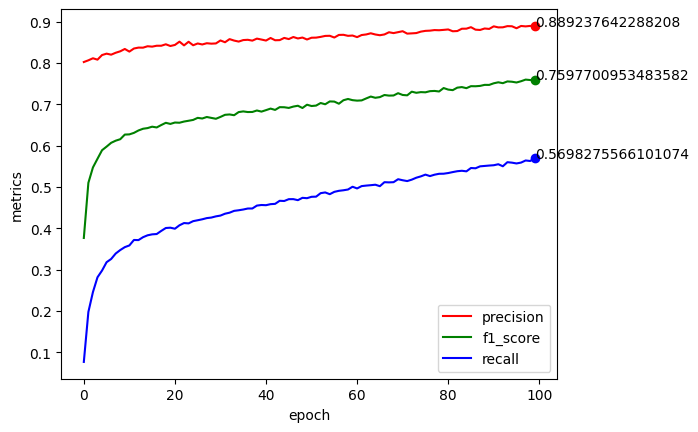

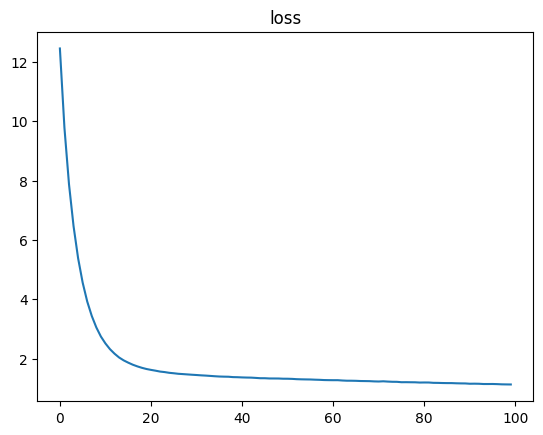

In [8]:
set_seeds(config.SEED)
# initialize the model
dense_model = DenseClassifier(input_shape=config.MODELS.get(config.MODEL_NAME).get("in_dim"),
num_classes=config.N_CLASSES,dropout=config.DROPOUT,l2_regularization=config.L2_REGULARIZATION,)
# initialize the trainer
trainer = ModelTrainer(
    dense_model, config.LEARNING_RATE, export_path=config.EXPORT_PATH
)
# compile the model
trainer.compile()
# get train, validation and test splits
train_split = pd.read_csv(
    f"{config.PARTITIONS_PATH}\\split01_train.csv", header=None, names=["filename"]
)
##train/valid split
train_split=train_split.sample(frac=0.7)
valid_split=train_split.drop(train_split.index)
# prepare dataloaders
trainloader = AudioDataLoader(
    train_split["filename"].tolist(),
    batch_size=config.BATCH_SIZE,
    dataset="train",
    shuffle=True,
)
# generate train and test datasets
train_dataset = trainloader.create_dataset()
# start training
trainer.train(train_dataset, epochs=config.EPOCHS)
# save the model
trainer.save_model()
# save the hyperparameters
export_hyperparams(trainer.runid, f"{trainer.export_path}\\hyperparams.json")
####get the Image representation for training
import json
import numpy as np
import matplotlib.pyplot as plt
with open(r'output\parameter\training.json', 'r') as fp:
    json_data = json.load(fp)
    y0 = json_data['loss']
    y1 = json_data['precision']
    y2 = json_data['f1_score']
    y3 = json_data['recall']
    x = np.arange(0, 100)
    plt.plot(x, y1, label='precision', c='r')
    plt.plot(x, y2, label='f1_score', c='g')
    plt.plot(x, y3, label='recall', c='b')
    plt.scatter(99, y1[99], c='r')
    plt.scatter(99, y2[99], c='g')
    plt.scatter(99, y3[99], c='b')
    plt.text(99, y1[99], y1[99])
    plt.text(99, y2[99], y2[99])
    plt.text(99, y3[99], y3[99])
    plt.xlabel('epoch')
    plt.ylabel('metrics')
    plt.legend()
    plt.show()
    plt.plot(x, y0)
    plt.title('loss')
    plt.show()